(101766, 50)
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No        

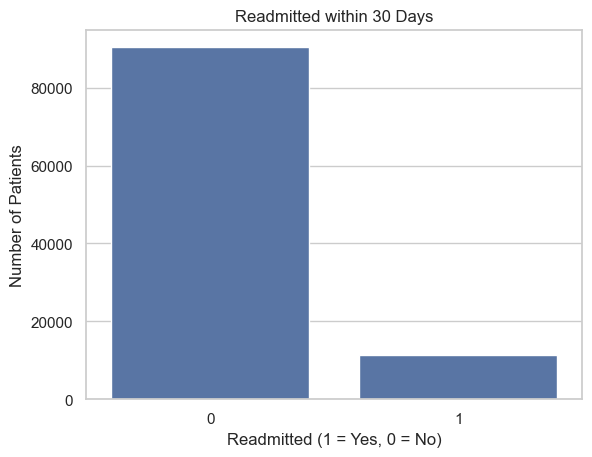

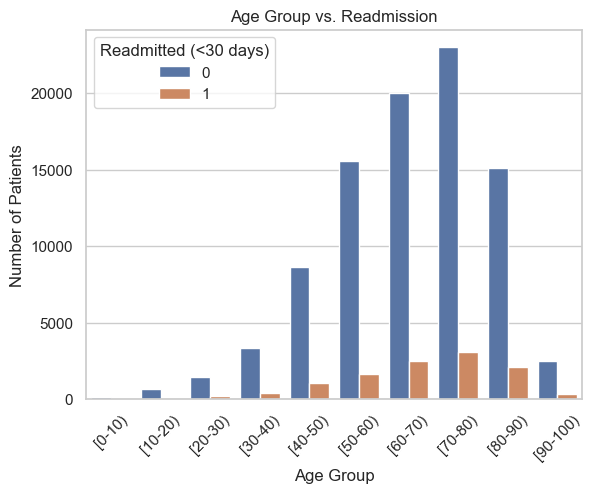

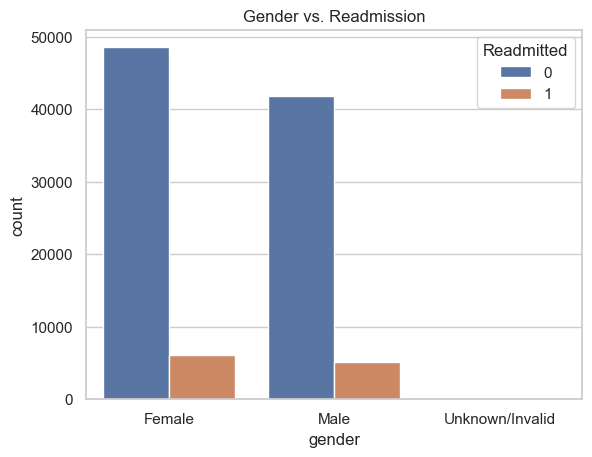

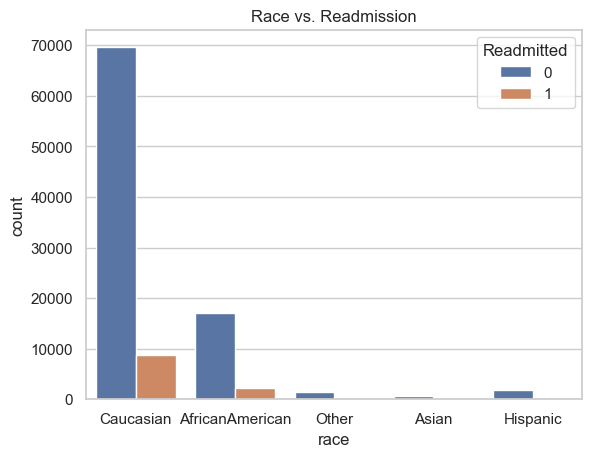

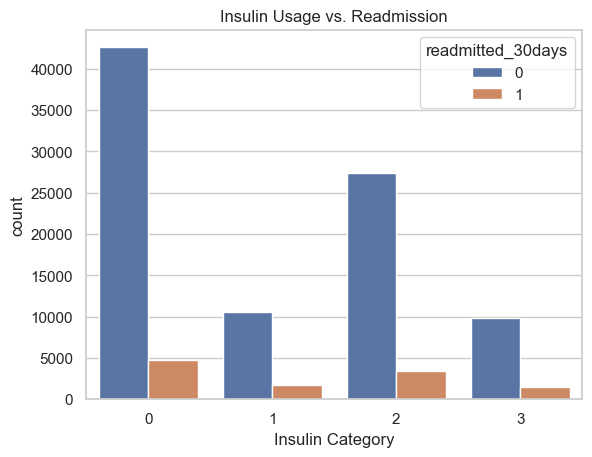

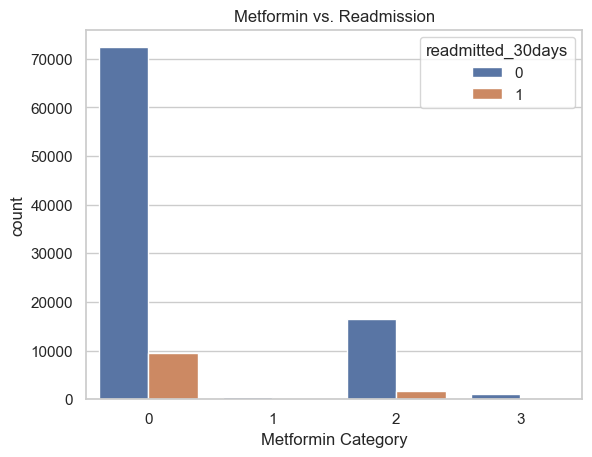

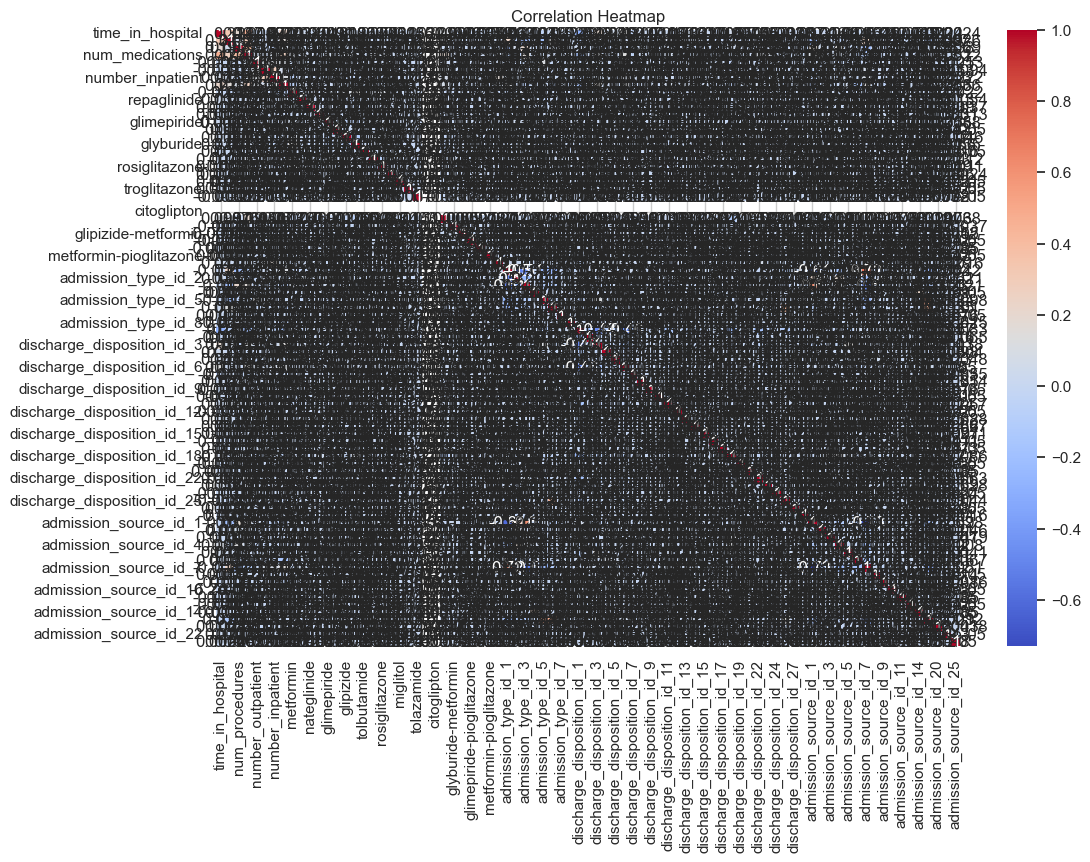

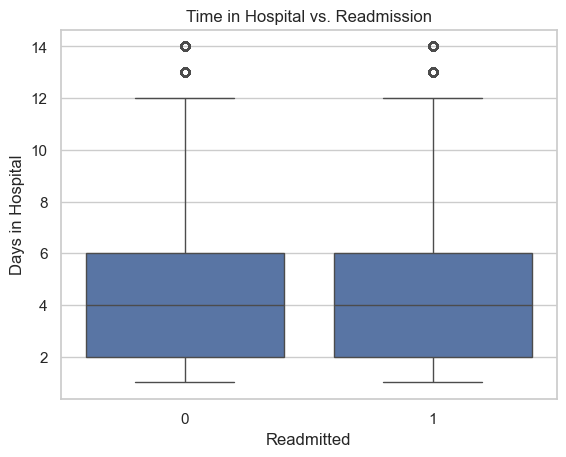

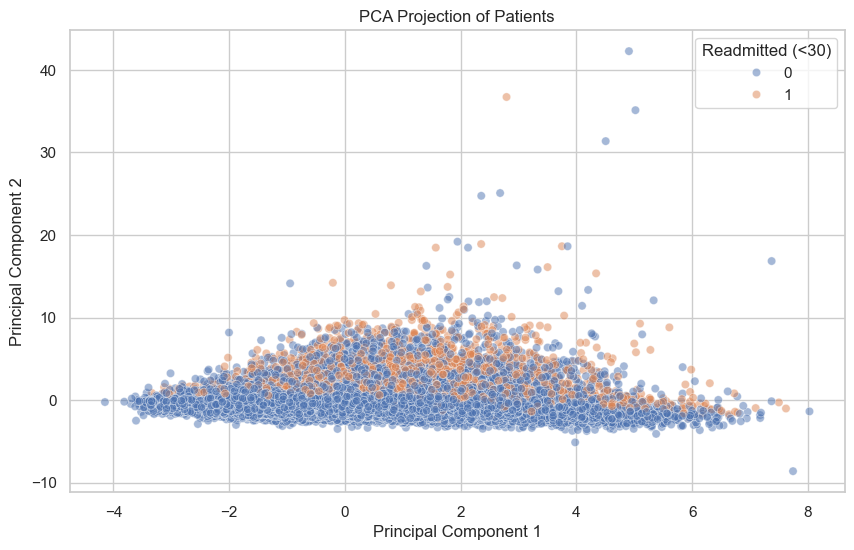

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# -------------- Importing Data set (as in the UCI website) -----------------#

from ucimlrepo import fetch_ucirepo 

diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
 
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 
  
# metadata 
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
print(diabetes_130_us_hospitals_for_years_1999_2008.variables) 

# Combine into a single DataFrame (since your code expects it)
def new_func(X, y):
    df = X.copy()
    if y is not None and not y.empty:
        df[y.columns[0]] = y.iloc[:, 0]
    return df

df = new_func(X, y)

print(df.shape)
print(df.head())
print(df.info())
print(df.describe())
print(df['readmitted'].value_counts())
#---------------------------------------------------------------------------#


#------------------------------ DATA CLEANING ------------------------------#

df.replace("?",np.nan,inplace=True)
missing_ratio=df.isnull().mean()
columns_to_drop=missing_ratio[missing_ratio>0.5].index
df.drop(columns=columns_to_drop,axis=1,inplace=True)

df.drop(['encounter_id','patient_nbr','admission_type_id','discharge_disposition_id','admission_source_id'],axis=1,inplace=True)

# Filling in missing Categorical Data 
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col]= df[col].fillna(df[col].mode()[0])

# Filling in missing Numerical Data
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col]= df[col].fillna(df[col].median())

#----------------------------------------------------------------------------#


#------------------------------ PRE-PROCESSING ------------------------------#

# Encoding "Yes an No" type of Values
label_cols = ['gender','change','diabetesMed']
le=LabelEncoder()
for cols in label_cols:
    df[col]=le.fit_transform(df[col])

# One-hot encode the 'age' and 'race' columns
df = pd.get_dummies(df, columns=['age', 'race'], prefix=['age', 'race'])


#df=pd.get_dummies(df,columns=['admission_type_id','discharge_disposition_id','admission_source_id'])

# Encoding The Medication Coloums
medication_cols=['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone']
med_map = {
    "No": 0, 
    "Down": 1, 
    "Steady": 2, 
    "Up": 3
}
for col in medication_cols:
    df[col] = df[col].map(med_map)


# Encoding  max_glu_serum and A1Cresult
max_glu_serum_map = {
    "none": 0,      
    "normal": 1,    
    ">200": 2,      
    ">300": 3       
}
df['max_glu_serum'] = df['max_glu_serum'].map(max_glu_serum_map)

a1c_result_map = {
    "none": 0,       
    "normal": 1,     
    ">7": 2,         
    ">8": 3          
}
df["A1Cresult"] = df["A1Cresult"].map(a1c_result_map)


# Encoding the  Readmitted coloum --> 0 = No readmission, 1 = Readmitted after 30 days, 2 = Readmitted within 30 days
def Readmitted(df):
    df['readmission_category'] = df['readmitted'].map({'No': 0, '>30': 1, '<30': 2})
Readmitted(df)


# ---------- PLOTTING COUNT PLOTS ----------

sns.set(style="whitegrid")
sns.countplot(x='readmitted_30days', data=df)
plt.title("Readmitted within 30 Days")
plt.xlabel("Readmitted (1 = Yes, 0 = No)")
plt.ylabel("Number of Patients")
plt.show()

# AGE Vs Readmittance
sns.countplot(x='age', hue='readmitted_30days', data=df)
plt.title("Age Group vs. Readmission")
plt.xlabel("Age Group")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.legend(title='Readmitted (<30 days)')
plt.show()

# GENDER Vs Readmittance
sns.countplot(x='gender', hue='readmitted_30days', data=df)
plt.title("Gender vs. Readmission")
plt.legend(title="Readmitted")
plt.show()

# RACE Vs Readmittance
sns.countplot(x='race', hue='readmitted_30days', data=df)
plt.title("Race vs. Readmission")
plt.legend(title="Readmitted")
plt.show()

# INSULIN Vs Readmittance
sns.countplot(x='insulin', hue='readmitted_30days', data=df)
plt.title("Insulin Usage vs. Readmission")
plt.xlabel("Insulin Category")
plt.show()

# SELECTED MEDS  Vs Readmittance
selected_meds = ['metformin', 'glimepiride', 'tolbutamide', 'tolazamide', 'chlorpropamide', 'pioglitazone']
# Plot countplots for each
for med in selected_meds:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=med, hue='readmitted_30days', data=df)
    plt.title(f'{med.capitalize()} vs. Readmission (<30 days)')
    plt.xlabel(f'{med.capitalize()} Category')
    plt.ylabel('Number of Patients')
    plt.legend(title='Readmitted')
    plt.tight_layout()
    plt.show()

# MAX_GLU_SERUM  Vs Readmittance
plt.figure(figsize=(6, 4))
sns.countplot(x='max_glu_serum', hue='readmitted_30days', data=df)
plt.title('Max Glucose Serum vs. Readmission (<30 days)')
plt.xlabel('Max Glucose Serum Result')
plt.ylabel('Number of Patients')
plt.legend(title='Readmitted')
plt.tight_layout()
plt.show()

# AC1results  Vs Readmittance
plt.figure(figsize=(6, 4))
sns.countplot(x='A1Cresult', hue='readmitted_30days', data=df)
plt.title('A1C Result vs. Readmission (<30 days)')
plt.xlabel('A1C Test Result')
plt.ylabel('Number of Patients')
plt.legend(title='Readmitted')
plt.tight_layout()
plt.show()

# TIME IN HOSPITAL Vs Readmittance
df['time_in_hospital']
sns.boxplot(x='readmitted_30days', y='time_in_hospital', data=df)
plt.title("Time in Hospital vs. Readmission")
plt.xlabel("Readmitted")
plt.ylabel("Days in Hospital")
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# --------------------------------------------

# ------- Principal Component Analysis -------

numeric_df = df.select_dtypes(include=['int64', 'float64'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['readmitted_30days'] = df['readmitted_30days']

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='readmitted_30days', alpha=0.5)
plt.title("PCA Projection of Patients")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Readmitted (<30)")
plt.show()

#----------------------------------------------------------------------------#
